# Exploratory data analysis

In this notebook, I perform some exploratory data analysis (EDA) of the EvaLatin dataset. The goal is to find insights that I can leverage in the modeling stage. This analysis is structured in four sections, each focusing on a different level of the data:

1. Dataset
2. Forms
3. POS
4. Lemmata

In [1]:
%load_ext blackcellmagic
%matplotlib inline
import os
import re
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from segments import Profile
from utils import read


from filenames import ROOT, RAW_EVALATIN_DATA, GRAPHEME_PROFILE

os.chdir(ROOT)
BLUE = sns.color_palette()[0]

In [2]:
# Read in all data into a single pyconll CoNLL structure
conll = read()

# Read in all data into a pandas DataFrame
data = []
for sentence in conll:
    for token in sentence:
        d = {"form": token.form, "lemma": token.lemma, "pos": token.upos}
        data.append(d)
df = pd.DataFrame(data)

### Dataset

#### Summary

- There are 14,399 sentences in the training data.
- There are 259,645 tokens in the training data. The official guidelines say 259,646 but I'm not too worried about this discrepency.
- Most (75%) sentences have under 24 tokens, with the average having 18. The vast majority (95%) of sentences have at most 40 tokens.
- There are no punctuation or end of sentence markers.

#### Notes

- Both the POS and lemmatization task make most sense at the sentence level, although you could try type-level approaches.
- The dataset is sizeable but not huge, so it could be worth investigating external unlabelled data, external labelled data and data augmentation methods
- Sentence lengths aren't too long, so models forgetting context is not a pressing concern.
- We'll have to add beginning and end of sentence markers.

In [3]:
# How many sentences are there?
len(conll)

14399

In [4]:
# How many tokens are there?
sum(map(len, conll))

259645

In [5]:
# What is the distribution of sentence length?
sentence_lengths = pd.Series([len(s) for s in conll])
sentence_lengths.describe()

count    14399.000000
mean        18.032155
std         12.556631
min          1.000000
25%         10.000000
50%         16.000000
75%         24.000000
max        328.000000
dtype: float64

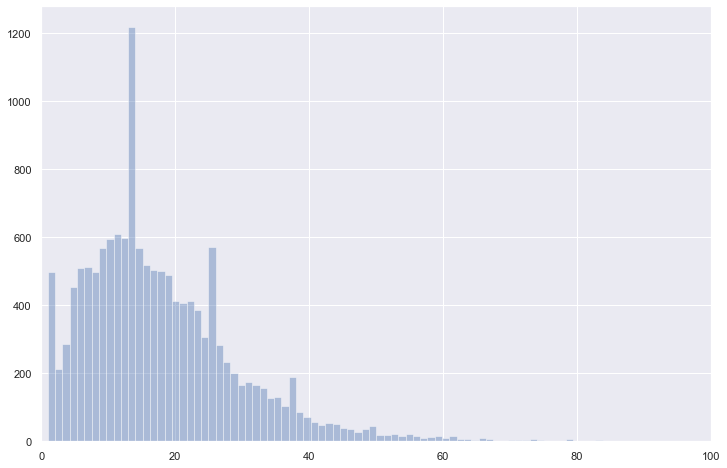

In [6]:
# Now we show sentence length visually
plt.figure(figsize=(12, 8))
plt.xlim((0, 100))
sns.distplot(sentence_lengths, bins=300, kde=False);

In [7]:
# This shows the percent of sentences with at most 40 tokens.
(sentence_lengths <= 40).value_counts(normalize=True) * 100

True     95.339954
False     4.660046
dtype: float64

### Forms

Here, we are counting characters not graphemes.

#### Summary

- There are 43,767 unique forms in the training data, of which more than half (24,376) only appear once. The vast majority (90%) of forms appear at most 7 times in the training data.
- Most forms have at most 8 characters, with the average form having around 6. The vast majority (95%) of words have at most 10 characters.
- There are 126 different characters in the training data.
- These characters fall into one of four classes:
    - Latin
    - Greek
    - Full stop
    - Other
- Over 98% of the Latin characters are lower case.
- Full stops are used in four different ways:
    - In abbreviations of proper nouns (following the regex `[A-Z].*\.`)
    - In lacunae (following the regex `\.\.\.`)
    - For the noun "salus", almost always preceded by "suus".
    - Other abbreviations, whose full form is not found elsewhere in the sentence.
- Capitalization is used in four different ways:
    - As the first character of a sentence
    - As the first character of a proper noun (abbreviated and not)
    - In Roman numerals
    - In "HS"
- About half the forms that end with "-que" are the clitic "-que".

#### Notes

- The large number of forms, and especially the large number of hapax legomena, suggest the need to include character-based methods.
- The large number of forms with few examples in the training data suggest that the test data will also have many infrequent forms too. This lends further support for character-based methods, and context-based methods.
- We can massively reduce the size of the character vocabulary by focusing on Latin characters.
- If we're just focusing on Latin characters, we could again halve the size of the character vocabulary if we focus on lower case characters. However, they are a huge signal for proper nouns (abbreviated or not).
- We could replace all Greek words with a single Greek character.

In [8]:
# What is the distribution of number of characters per form?
word_lengths = df["form"].str.len()
word_lengths.describe()

count    259645.000000
mean          5.899802
std           2.766474
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          20.000000
Name: form, dtype: float64

In [9]:
# This shows the percent of words with at most 10 characters.
(word_lengths <= 10).value_counts(normalize=True) * 100

True     94.172043
False     5.827957
Name: form, dtype: float64

In [10]:
# What is the character set used in the forms?
chars = pd.Series(list("".join(df["form"].values)))
chars.value_counts()

i    178050
e    175860
u    145667
a    125529
t    124390
      ...  
Ἐ         1
Κ         1
ὕ         1
̔         1
ἱ         1
Length: 126, dtype: int64

In [11]:
# What classes of characters are there?
char_class = lambda ch: unicodedata.name(ch).split()[0]
pd.Series(chars.unique()).apply(char_class).value_counts()

GREEK             74
LATIN             47
APOSTROPHE         1
COMBINING          1
FULL               1
RIGHT-POINTING     1
LEFT-POINTING      1
dtype: int64

In [12]:
# What is the distribution of upper and lower Latin characters?
is_latin = lambda ch: char_class(ch) == "LATIN"
case = lambda ch: "upper" if ch.isupper() else "lower"
chars_df = chars.to_frame("char")
chars_df["latin"] = chars_df["char"].apply(is_latin)
chars_df["case"] = chars_df["char"].apply(case)
chars_df[chars_df["latin"]]["case"].value_counts(normalize=True)

lower    0.985058
upper    0.014942
Name: case, dtype: float64

In [13]:
# How are full stops used?
full_stop_pattern = re.compile(r"\.")
has_full_stop = df["form"].str.contains(full_stop_pattern)
df[has_full_stop]["pos"].value_counts()

PROPN    984
NOUN     220
ADP        5
X          3
ADJ        2
Name: pos, dtype: int64

In [14]:
# abbreviations
abbreviation_pattern = re.compile(r"[A-Z].*\.")
is_abbreviation = df["form"].str.contains(abbreviation_pattern)
df[is_abbreviation]["pos"].value_counts()

PROPN    984
NOUN       3
ADJ        2
Name: pos, dtype: int64

In [15]:
# lacunae
lacuna_pattern = re.compile(r"\.\.\.")
is_lacuna = df["form"].str.contains(lacuna_pattern)
df[is_lacuna]

,form,lemma,pos
217979,p...,uox_lacunosa,X
244065,...,uox_lacunosa,X
247156,...,uox_lacunosa,X


In [16]:
# salus
is_salus = df["lemma"] == "salus"
pd.Series(
    [df.loc[i - 1]["form"] for i in df[has_full_stop & is_salus].index]
).value_counts()

suo        197
suae         8
Cottiae      1
Socrui       1
dtype: int64

In [17]:
# remaining
df[has_full_stop & ~is_abbreviation & ~is_lacuna & ~is_salus]["form"].value_counts()

d.       5
a.       5
f.       3
coss.    1
kal.     1
Name: form, dtype: int64

In [18]:
# How is capitalization used?
capital_pattern = re.compile(r"[A-Z]")
has_capital_letter = df["form"].str.contains(capital_pattern)
df[has_capital_letter]

,form,lemma,pos
0,Dum,dum,SCONJ
3,Hispania,Hispania,PROPN
5,C.,Gaius,PROPN
6,Trebonius,Trebonius,PROPN
11,Massiliae,Massilia,PROPN
...,...,...,...
259638,Syria,Syria,PROPN
259639,Aponius,Aponius,PROPN
259641,Moesia,Moesia,PROPN
259642,Flauianus,Flauianus,PROPN


In [19]:
# How many unique forms are there?
len(df["form"].unique())

43767

In [20]:
# How many hapax legomena are there?
word_counts = df["form"].value_counts()
(word_counts == 1).sum()

24376

In [21]:
(word_counts <= 7).value_counts(normalize=True)

True     0.90173
False    0.09827
Name: form, dtype: float64

In [22]:
# How many forms have the clitic "-que"?
que_form = df["form"].str.endswith("que")
df[que_form]["lemma"].str.endswith("que").value_counts(normalize=True)

False    0.538761
True     0.461239
Name: lemma, dtype: float64

### POS

#### Summary

- There are 15 different POS tags, just as the official guideline states.
- Nouns and verbs are by far the most frequent POS tags.
- By frequency, there are three classes of POS tags:
    - NOUN and VERB are in the most frequenct class, each accounting for around 23% of all tokens, totalling over 45% together. 
    - The next class consists of ADJ, ADV, PRON, DET, CCONJ, ADP, PROPN, SCONJ and PART tags, and each account for 1-8% of tags.
    - The last class consists of AUX, NUM, X and INTJ tags, which each account for less than 1% of tokens.
- NOUN, VERB, ADJ and PRON need root, morphology and syntactic context to identify them.
- ADV, DET, ADP and CCONJ are more tied to a particular form/root.
- PART is only negatives "non", "ne" and "haud",  but these can also be SCONJ or ADV.
- AUX are forms of sum or eo, as the official guide mentions.
- NUM are cardinal numbers or roman numerals.
- INTJ can largely be distinguished by their form, which comes from a small set of forms (most are "O" or "hercule"). However, there is still variation ("age", "malus"). Context should identify them. Most of the "O" INTJ are sentence-initial.

#### Notes

- As a baseline, if you just guessed NOUN for each token, you'd have an accuracy of 23%.
- The different information useful to identify the POS are root, the inflectional morphology, the derivational morphology, the syntactic context and the linear order in the sentence.
- Having contextual models is important.
- Having word-type representations is important for those tags that are strongly lexical (e.g. CCONJ, DET, ADV, INTJ).
- Having character-based models is important for those with morphology.
- Having sentence position information will help identify some tags (e.g. INTJ), so we should include beginning and end of sentence markers.
- Add end of word markers to help model suffixes.
- Start/end sentence marker, start/end word marker, characters and type representations.

In [23]:
# How many POS tags are there?
len(df["pos"].unique())

15

In [24]:
# What is the distribution of POS tags?
df["pos"].value_counts(normalize=True) * 100

NOUN     23.899940
VERB     22.632826
ADJ       8.295172
ADV       7.928903
PRON      7.569951
DET       6.373317
CCONJ     6.170733
ADP       6.082151
PROPN     4.872037
SCONJ     3.263687
PART      1.512065
AUX       0.663213
NUM       0.613145
X         0.071251
INTJ      0.051609
Name: pos, dtype: float64

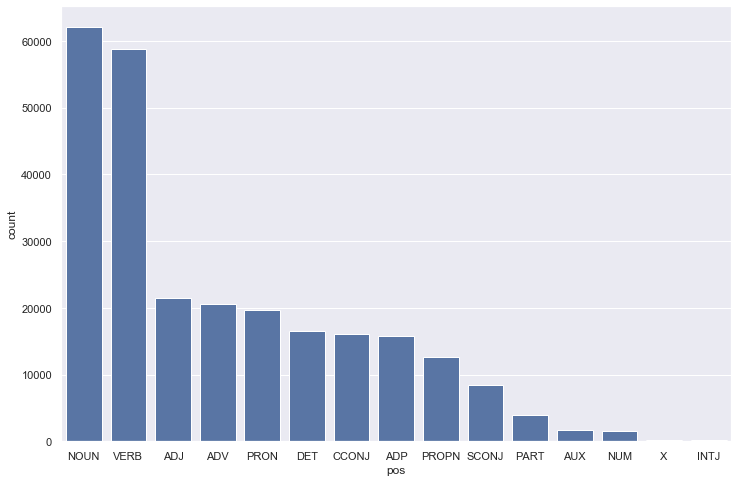

In [25]:
# Now we show it visually with raw counts
order = df["pos"].value_counts().index
plt.figure(figsize=(12, 8))
sns.countplot(x="pos", data=df, order=order, color=BLUE);

In [26]:
# What do NOUN look like?
# Not much here beyond normal Latin morphology
noun = df["pos"] == "NOUN"
noun_counts = df[noun]["form"].value_counts()
noun_counts.head()

beneficium    399
rei           364
causa         315
res           310
re            283
Name: form, dtype: int64

In [27]:
# What do VERB look like?
# Not much here beyond normal Latin morphology
verb = df["pos"] == "VERB"
verb_counts = df[verb]["form"].value_counts()
verb_counts.head()

est     2085
esse     798
sunt     445
sit      377
fuit     336
Name: form, dtype: int64

In [28]:
# What do ADJ look like?
# Not much here beyond normal Latin morphology
adj = df["pos"] == "ADJ"
adj_counts = df[adj]["form"].value_counts()
adj_counts.head()

publicae    244
Romani      212
publica     190
magna       168
multa       160
Name: form, dtype: int64

In [29]:
# What do ADV look like?
adv = df["pos"] == "ADV"
adv_counts = df[adv]["form"].value_counts()
adv_counts.head()

quam      1320
etiam      939
ut         790
tamen      642
quidem     641
Name: form, dtype: int64

In [30]:
# What do PRON look like?
pron = df["pos"] == "PRON"
pron_counts = df[pron]["form"].value_counts()
pron_counts.head()

qui     1807
quae    1253
quod    1189
se      1139
me       738
Name: form, dtype: int64

In [31]:
# What do DET look like?
det = df["pos"] == "DET"
det_counts = df[det]["form"].value_counts()
det_counts.head()

hoc     771
ipse    381
ille    366
haec    358
illi    351
Name: form, dtype: int64

In [32]:
# What do CCONJ look like?
cconj = df["pos"] == "CCONJ"
cconj_counts = df[cconj]["form"].str.lower().value_counts()
cconj_counts.head()

et      6651
sed     1606
enim    1015
aut      997
ac       968
Name: form, dtype: int64

In [33]:
# What do ADP look like?
adp = df["pos"] == "ADP"
adp_counts = df[adp]["form"].str.lower().value_counts()
adp_counts.head()

in    4889
ad    2163
ex    1253
a     1138
de     896
Name: form, dtype: int64

In [34]:
# What do PART look like?
part = df["pos"] == "PART"
part_counts = df[part]["form"].str.lower().value_counts()
part_counts.head()

non     3558
ne       294
haud      74
Name: form, dtype: int64

In [35]:
negatives = ["non", "ne", "haud"]
df[df["form"].isin(negatives)]["pos"].value_counts()

PART     3704
SCONJ     569
ADV         7
Name: pos, dtype: int64

In [36]:
# What do PROPN look like?
propn = df["pos"] == "PROPN"
df[propn]["form"].value_counts().head(20)

C.           369
Caesar       329
Plinius      210
Caesaris     185
M.           181
Caesarem     151
L.           133
Antonius     127
Galliae       89
Uitellio      87
Antoni        83
Uitellium     83
Antonium      80
Gallia        77
Uitellius     75
Uitellii      71
Galliam       68
Caesare       65
Antonio       64
Rhenum        62
Name: form, dtype: int64

In [37]:
# What do AUX look like?
aux = df["pos"] == "AUX"
aux_counts = df[aux]["form"].str.lower().value_counts()
aux_counts.head()

est      779
sunt     193
esse     156
sit       89
esset     83
Name: form, dtype: int64

In [38]:
# What do NUM look like?
num = df["pos"] == "NUM"
num_counts = df[num]["form"].str.lower().value_counts()
num_counts.head()

unum     133
milia    125
uno       88
una       83
duo       59
Name: form, dtype: int64

In [39]:
# What do INTJ look like?
intj = df["pos"] == "INTJ"
df[intj]["form"].str.lower().value_counts()

o             75
mehercules    10
ecce          10
hercule       10
age            5
mehercule      5
en             4
agedum         3
malum          2
io             2
pro            2
heu            2
hercules       1
heus           1
heia           1
medius         1
Name: form, dtype: int64

In [40]:
# How many O's begin a sentence?
len([sentence for sentence in conll if sentence[0].form.lower() == "o"])

62

In [41]:
# What do X look like?
X = df["pos"] == "X"
df[X]["lemma"].value_counts()

uox_graeca      181
uox_lacunosa      3
x〈sc〉             1
Name: lemma, dtype: int64

### Lemmatization

#### Summary

- There are 9,623 unique lemmata.
- sum, qui and et each account for over 2% of tokens.
- The top 20 lemmata account for almost a quarter of all tokens.
- A third of the training data have the lemma identical to the form.
- Less than 3% of the surface forms have more than one lemmata. This drops to less than 1% if you know the part of speech.
- Capitalization of the lemma seems to follow that of the form, except in sentence initial positions.


#### Notes
- Lacunae can be lemmatized with the regular expression `\.\.`
- Greek words can be lemmatized with the `is_greek_function`.
- The Roman numeral regex by itself isn't working well enough at the moment to use it. It makes more false positives than true positives in the training data, although it makes no (correct) false negatives). But if part of speech is NUM or ADJ then it's perfect.
- You can get almost perfect accuracy (99%) within the training data by using the lemma found in the training data for that surface form and part of speech. Many of the examples that you'd get wrong seem to be incorrectly annotated.
- This memorization approach won't help with unseen forms though, so we can still train a model for this.

In [42]:
# How many lemmata are there?
len(df["lemma"].unique())

9623

In [43]:
# What is the distribution of lemata?
(df["lemma"].value_counts(normalize=True) * 100).head(20)

sum      2.947871
qui      2.723719
et       2.561574
in       1.883726
non      1.369947
is       1.308325
hic      1.149261
ut       1.070693
cum      0.836527
ad       0.833061
ille     0.787614
quis     0.730228
ab       0.716748
sui      0.709815
ego      0.691714
res      0.647808
si       0.640490
omnis    0.636253
sed      0.621618
suus     0.586955
Name: lemma, dtype: float64

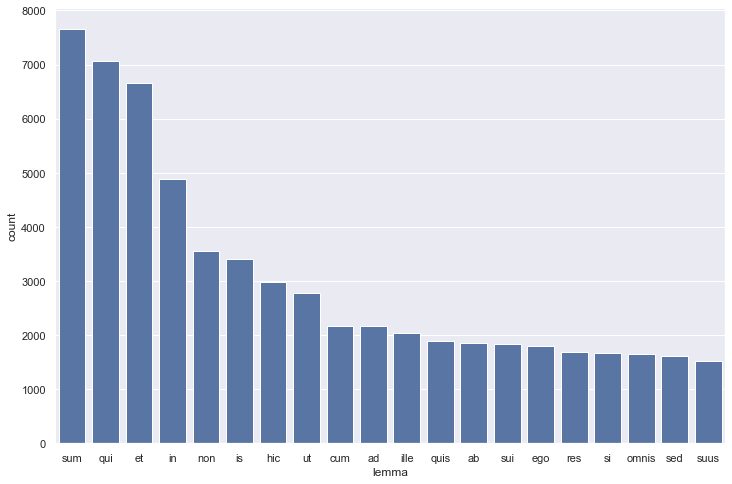

In [81]:
# What is the distribution of lemma?
# Now we show it visually with raw counts for the top N lemmata
N = 20
order = df["lemma"].value_counts().iloc[:N].index
plt.figure(figsize=(12, 8))
sns.countplot(x="lemma", data=df, order=order, color=BLUE);

In [45]:
(df["lemma"].value_counts(normalize=True) * 100).iloc[:20].sum()

23.45394673496505

In [46]:
# What is the distribution of number of POS tags per lemma?
num_pos_per_lemma = df.groupby("lemma")["pos"].nunique().to_frame("count")
num_pos_per_lemma["count"].describe()

count    9623.000000
mean        1.022238
std         0.150948
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: count, dtype: float64

In [47]:
# How often are the form and lemma identical?
(df["form"].str.lower() == df["lemma"]).value_counts(normalize=True)

False    0.659027
True     0.340973
dtype: float64

In [48]:
# Lacunae
is_lacuna = df["lemma"] == "uox_lacunosa"
has_two_periods = df["form"].str.contains("\.\.")
df[is_lacuna] == df[has_two_periods]

,form,lemma,pos
217979,True,True,True
244065,True,True,True
247156,True,True,True


In [49]:
# Greek words
def is_greek_char(ch):
    return char_class(ch) == "GREEK"


def is_greek_word(word):
    return any(map(is_greek_char, word))


# Does the `is_greek_word` function find only Greek words?
df[df["form"].apply(is_greek_word)]["lemma"].value_counts()

uox_graeca    183
Name: lemma, dtype: int64

In [50]:
# Does the `is_greek_word` function miss any Greek words?
(df[~df["form"].apply(is_greek_word)]["lemma"] == "uox_graeca").value_counts()

False    259462
Name: lemma, dtype: int64

In [51]:
# Roman numerals
roman_numeral_pattern = re.compile(
    r"^M{0,4}(CM|CD|D?C{0,4})(XC|XL|L?X{0,4})(IX|I[VU]|[VU]?I{0,4})$", re.IGNORECASE
)
is_really_roman_numeral = df["lemma"] == "numerus_romanus"
is_predicted_roman_numeral = df["form"].str.match(roman_numeral_pattern)
df[~is_really_roman_numeral & is_predicted_roman_numeral].head()

,form,lemma,pos
1805,ui,uis,NOUN
2009,diu,diu,ADV
2759,cui,qui,PRON
3956,cui,qui,PRON
5756,cui,qui,PRON


In [52]:
df[~is_really_roman_numeral & is_predicted_roman_numeral][
    "form"
].str.lower().value_counts()

cui    265
diu     99
di      58
ui      57
ii      13
mi       8
i        3
d        1
c        1
Name: form, dtype: int64

In [147]:
df[~is_really_roman_numeral & is_predicted_roman_numeral]["pos"].value_counts()

PRON     278
NOUN     116
ADV       99
DET        8
VERB       3
PROPN      1
Name: pos, dtype: int64

In [59]:
# What is the distribution of number of lemmata per surface form?
df.groupby("form")["lemma"].nunique().describe()

count    43767.000000
mean         1.029931
std          0.182319
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: lemma, dtype: float64

In [63]:
# How many surface forms have more than one lemma?
(df.groupby("form")["lemma"].nunique() > 1).value_counts(normalize=True)

False    0.972102
True     0.027898
Name: lemma, dtype: float64

In [107]:
# How many surface forms and POS combinations have more than one lemma?
(df.groupby(["form", "pos"])["lemma"].nunique() > 1).value_counts(normalize=True)

False    0.995373
True     0.004627
Name: lemma, dtype: float64

In [141]:
# What are these combinations?
tmp = df.groupby(["form", "pos"])["lemma"].nunique() > 1
ambiguous = tmp[tmp]
ambiguous.tail()

form         pos 
uisus        VERB    True
uniuersi     NOUN    True
uniuersorum  NOUN    True
uoluerit     VERB    True
uoluit       VERB    True
Name: lemma, dtype: bool

In [80]:
# Does word initial capitalization of the lemma reflect that found in the form?
(df["form"].str[0].str.isupper() != df["lemma"].str[0].str.isupper()).value_counts(normalize=True)

False    0.96159
True     0.03841
dtype: float64